In [2]:
import astropy.units as u
from astroquery.xmatch import XMatch
from astropy.table import Column,QTable
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
from astroquery.xmatch import XMatch
import numpy as np
import pandas as pd
from astropy.io import ascii

coord = SkyCoord("04:30:47.99", "+64:50:56.5", unit=(u.hourangle, u.deg), frame='icrs')
rad = 6 * u.arcminute

catalogs = ['vizier:I/350/gaiaedr3', 'vizier:II/246/out', 'vizier:II/328/allwise', 'vizier:II/349/ps1']

data = pd.DataFrame()
df_gaia = QTable(names=('RA_ICRS','DE_ICRS'))
data_2mass = QTable()
data_wise = QTable()
data_panstarrs = QTable()

df_gaia = QTable(names=('RA_ICRS', 'DE_ICRS', 'Gmag'))
df_2mass = QTable(names=('RAJ2000', 'DEJ2000', 'Jmag', 'Hmag', 'Kmag'))
df_wise = QTable(names=('RAJ2000', 'DEJ2000', 'W1mag', 'W2mag', 'W3mag', 'W4mag'))
df_panstarrs = QTable(names=('RAJ2000', 'DEJ2000', 'gmag', 'rmag'))

result_table = Vizier.query_region(coord, radius=rad, catalog='I/350/gaiaedr3')
df_gaia = result_table[0]['RA_ICRS','DE_ICRS', 'Gmag', 'e_Gmag']

       
data_2mass = XMatch.query(cat1=df_gaia,
                     cat2=catalogs[1],
                     max_distance=3*u.arcsec,
                     colRA1='RA_ICRS', colDec1='DE_ICRS')

data_wise = XMatch.query(cat1=data_2mass,
                     cat2=catalogs[2],
                     max_distance=3*u.arcsec,
                     colRA1='RA_ICRS', colDec1='DE_ICRS')

data_panstarrs = XMatch.query(cat1=data_wise,
                     cat2=catalogs[3],
                     max_distance=3*u.arcsec,
                     colRA1='RA_ICRS', colDec1='DE_ICRS')

mag = [['Gmag', 'e_Gmag'], ['Jmag_2', 'e_Jmag_2'],['Hmag_2', 'e_Hmag_2'], ['Kmag_2', 'e_Kmag_2'],
       ['W1mag', 'e_W1mag'], ['W2mag', 'e_W2mag'], ['W3mag', 'e_W3mag'], ['W4mag', 'e_W4mag'],
       ['gmag', 'e_gmag'], ['rmag', 'e_rmag'], ['imag', 'e_imag'], ['zmag', 'e_zmag'], ['ymag', 'e_ymag']]

name = [['G_flux', 'e_G_flux', 'G_wl'],
         ['J_flux', 'e_J_flux', 'J_wl'],
         ['H_flux', 'e_H_flux', 'H_wl'],
         ['K_flux', 'e_K_flux', 'K_wl'],
         ['W1_flux', 'e_W1_flux', 'W1_wl'],
         ['W2_flux', 'e_W2_flux', 'W2_wl'],
         ['W3_flux', 'e_W3_flux', 'W3_wl'],
         ['W4_flux', 'e_W4_flux', 'W4_wl'],
         ['g_flux', 'e_g_flux', 'g_wl'],
         ['r_flux', 'e_r_flux', 'r_wl'],
         ['i_flux', 'e_i_flux', 'i_wl'],
         ['z_flux', 'e_z_flux', 'z_wl'],
         ['y_flux', 'e_y_flux', 'y_wl']]

ZP = [3229, 1594, 1024, 666.7, 309.54, 171.79, 31.676, 8.3635, 3964.03, 3173.02, 2575.36, 2261.81, 2180.4]
wl = [690, 1235, 1662, 2159, 3368, 4618, 12082, 22194, 481, 617, 752, 866, 962]

data['RA_ICRS'] = data_panstarrs['RA_ICRS']
data['DE_ICRS'] = data_panstarrs['DE_ICRS']

for i in range(len(ZP)):
    for j in range(2):
        data[mag[i][j]] = data_panstarrs[mag[i][j]]
data.fillna(0., inplace=True)

for i in range(len(name)):
    data[name[i][0]] = ZP[i]*10**(-0.4*data[mag[i][0]])
    data[name[i][1]] = data[mag[i][1]]*0.4*ZP[i]*10**(-0.4*data[mag[i][0]])*np.log(10)
    data[name[i][2]] = wl[i]*len(ZP)


Could not import regions, which is required for some of the functionalities of this module.


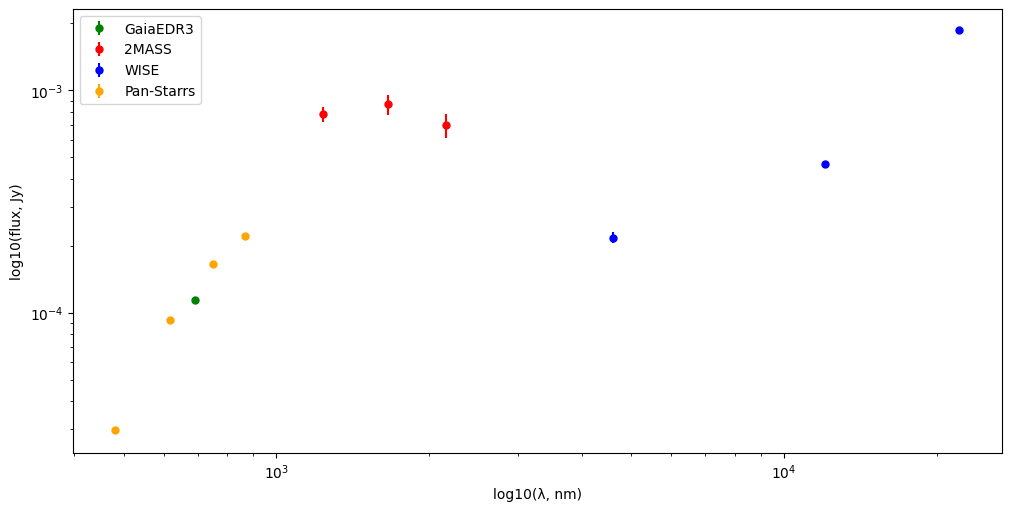

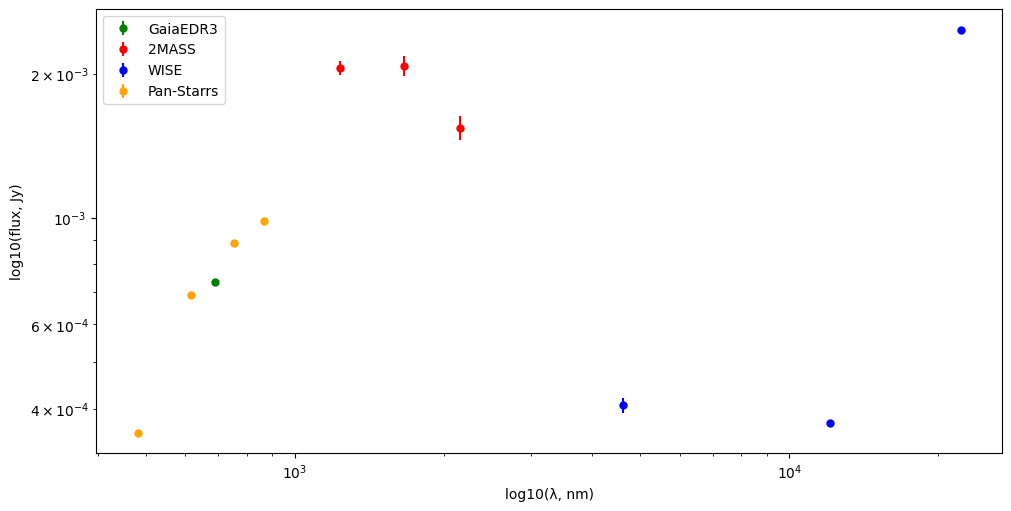

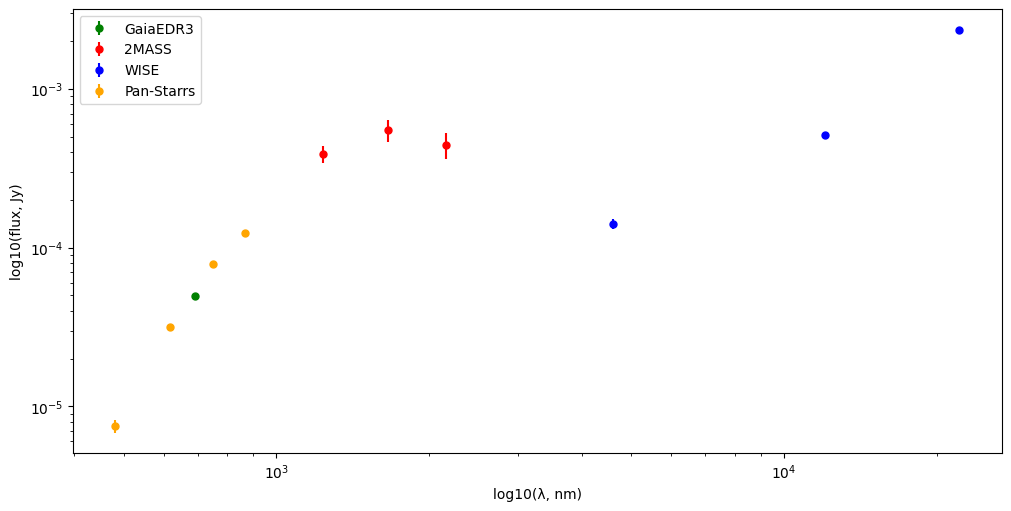

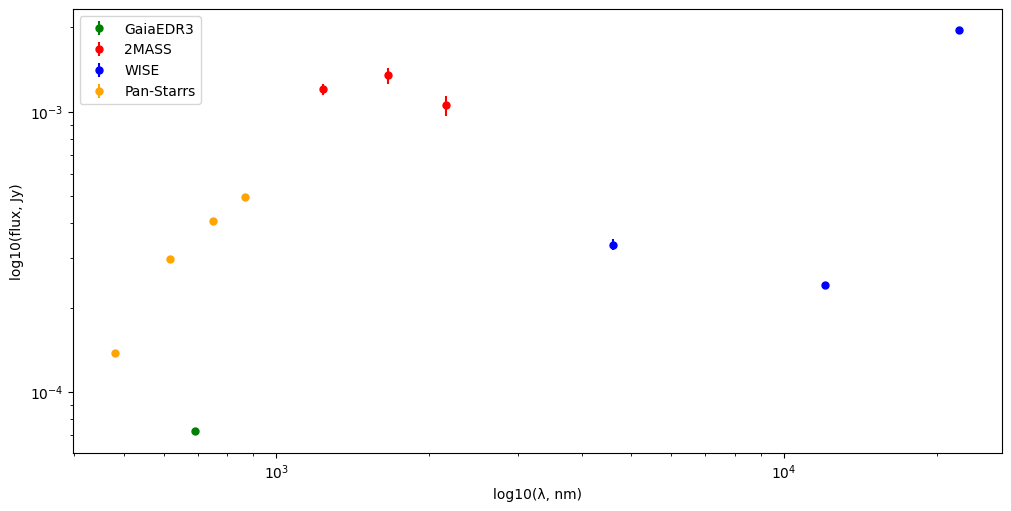

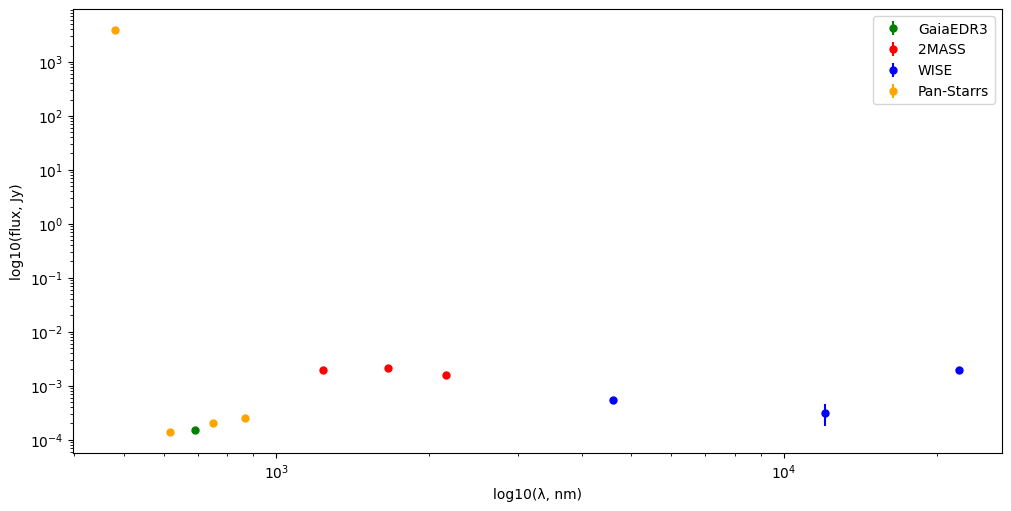

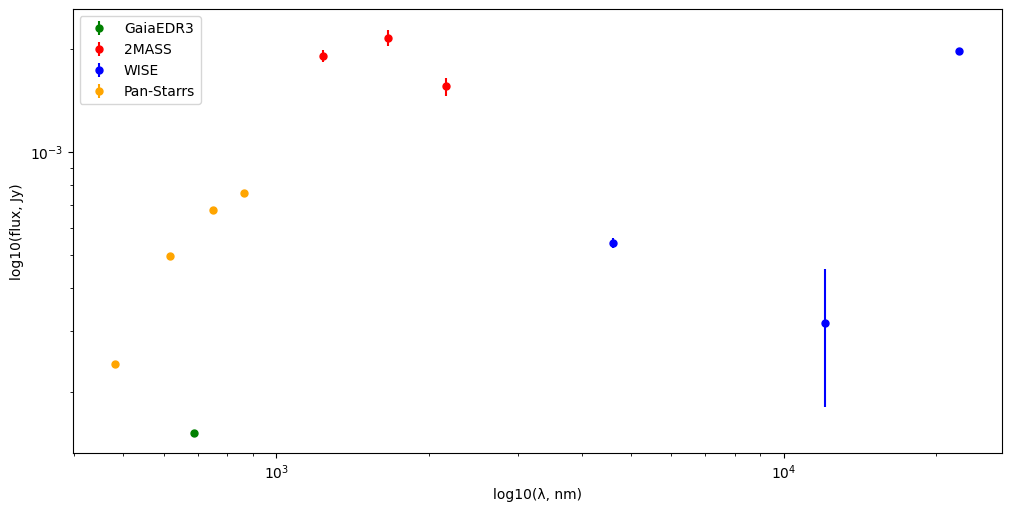

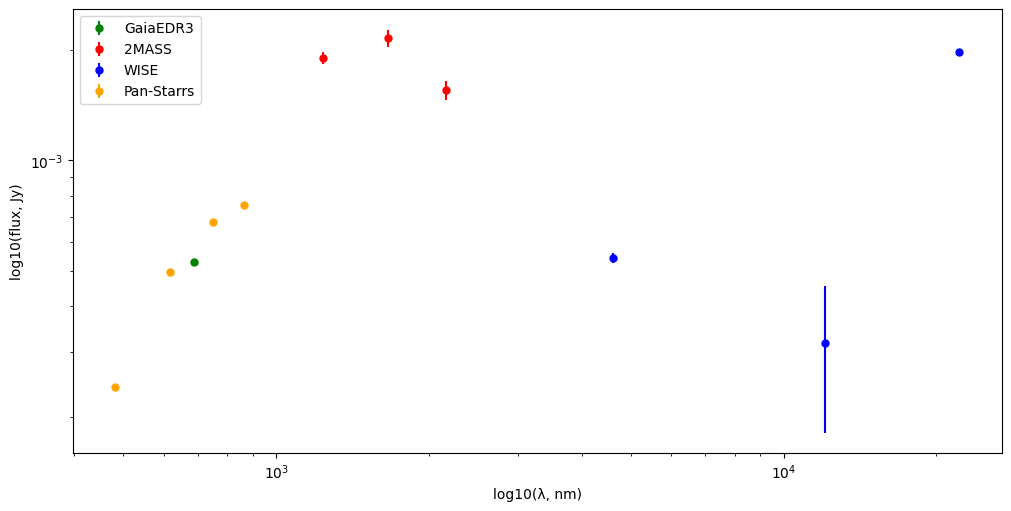

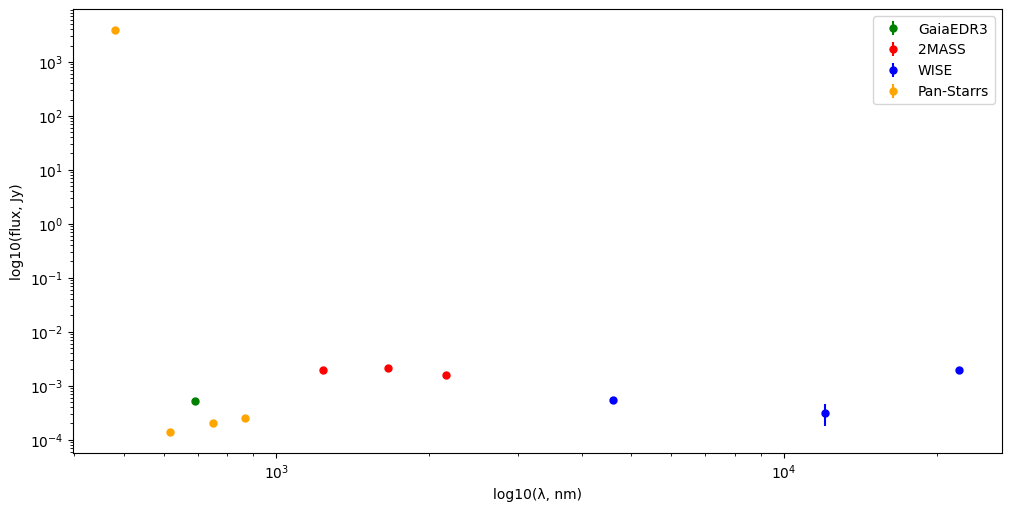

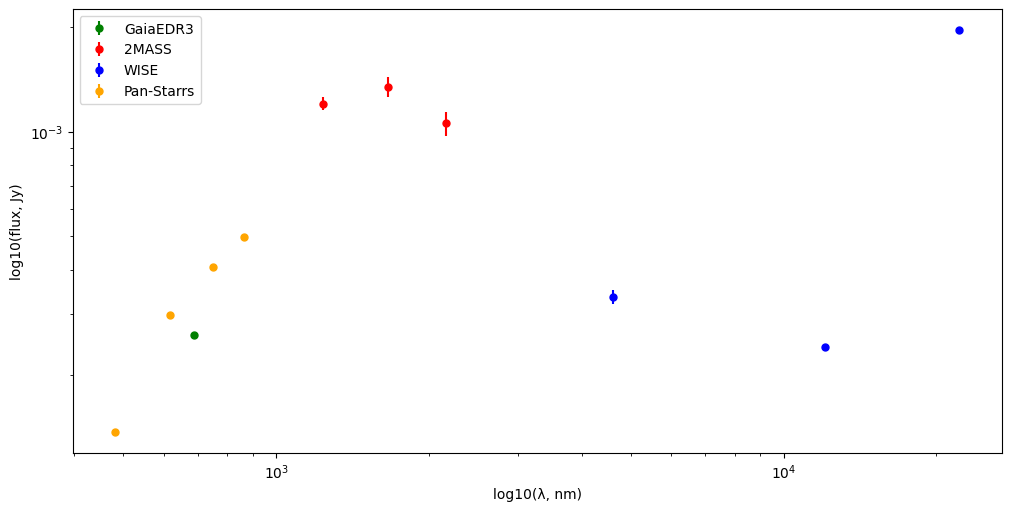

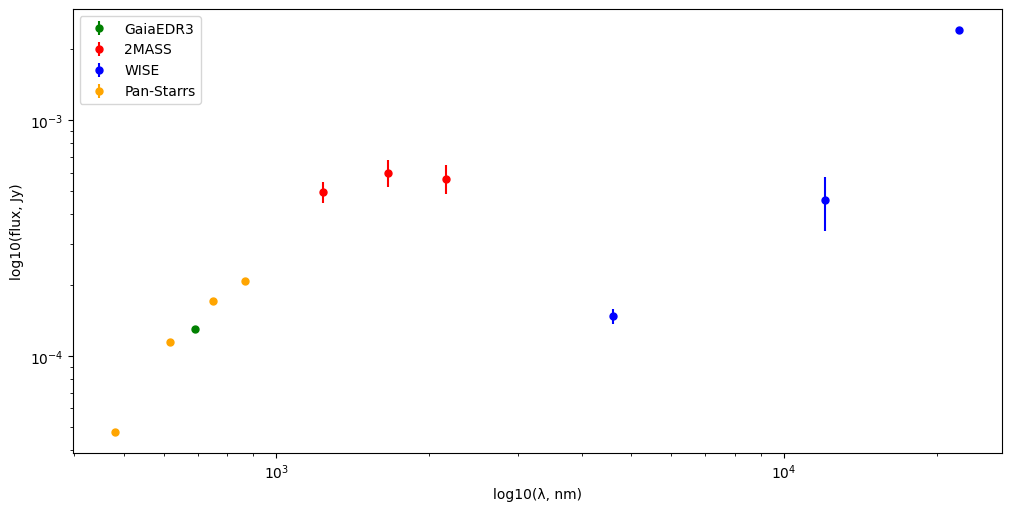

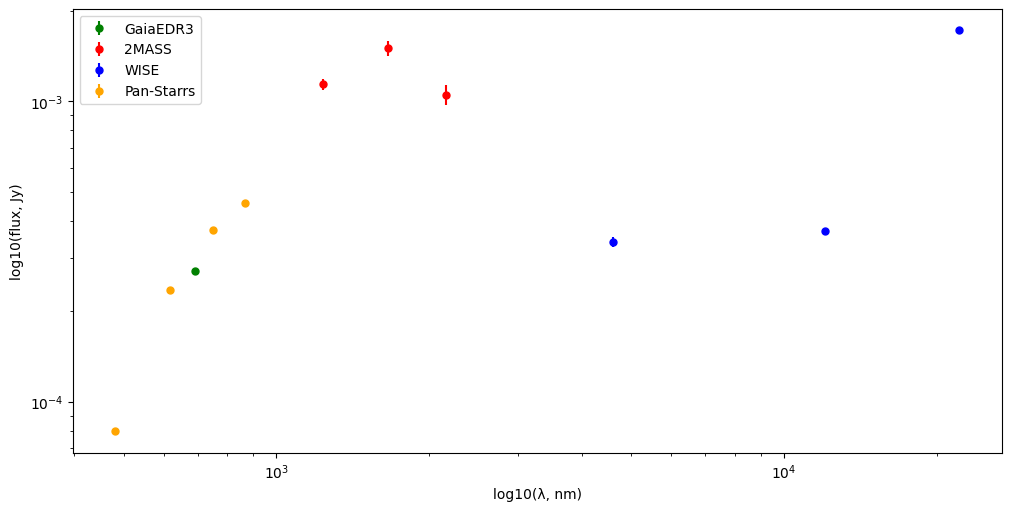

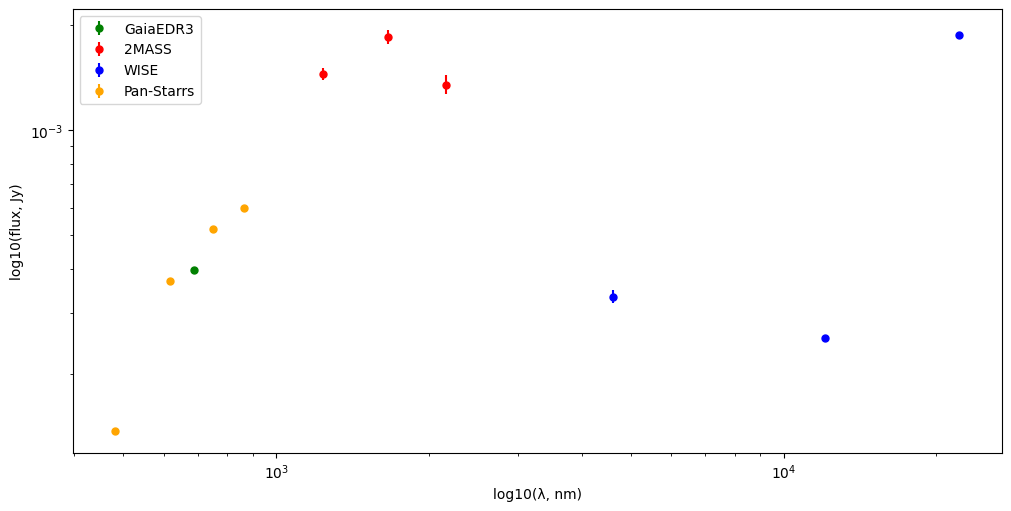

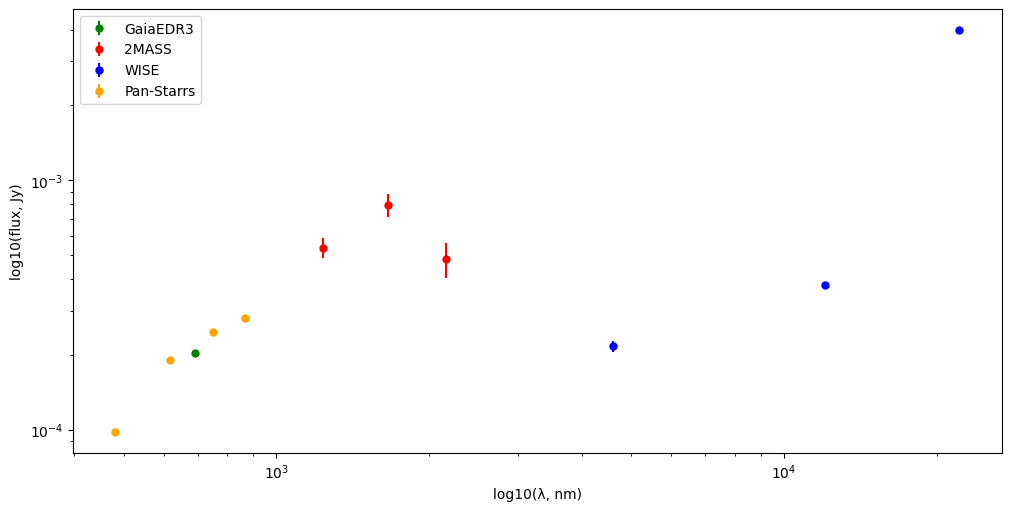

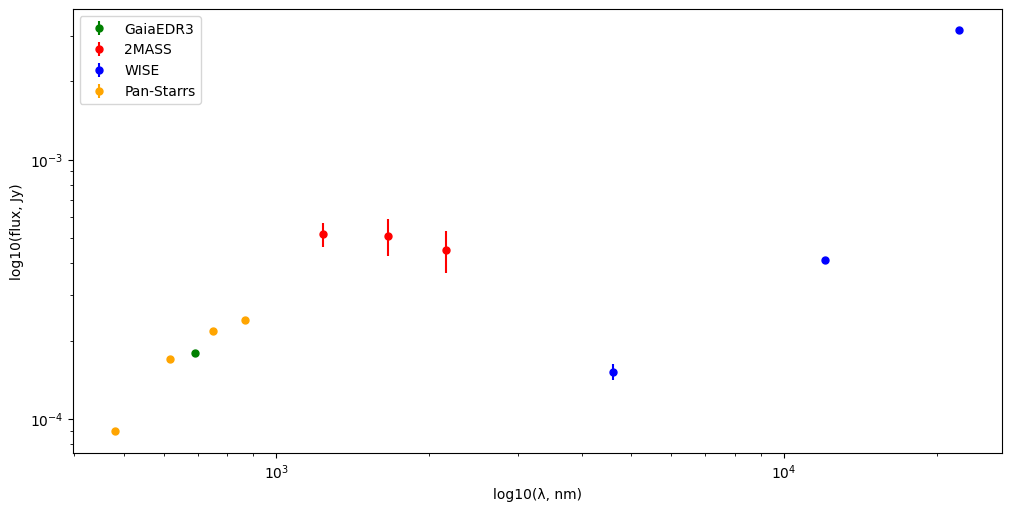

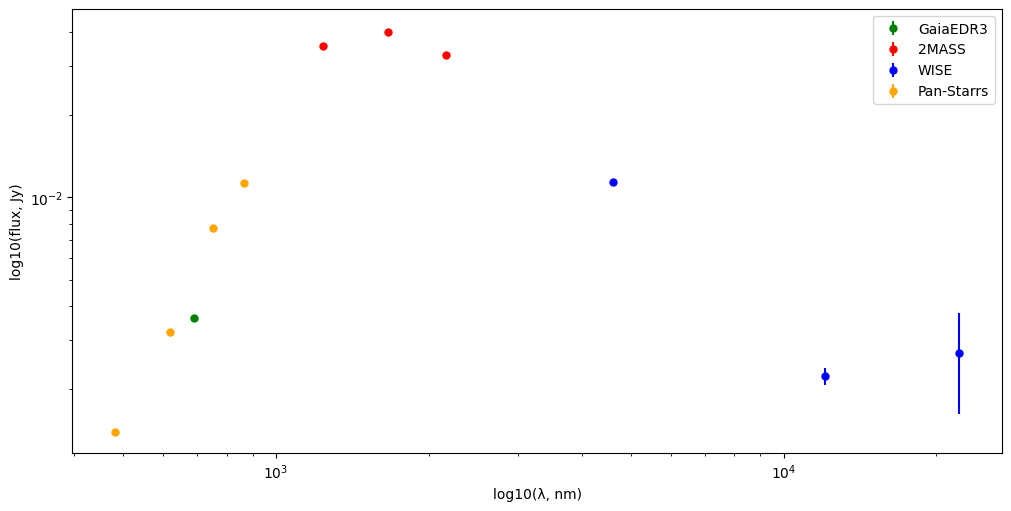

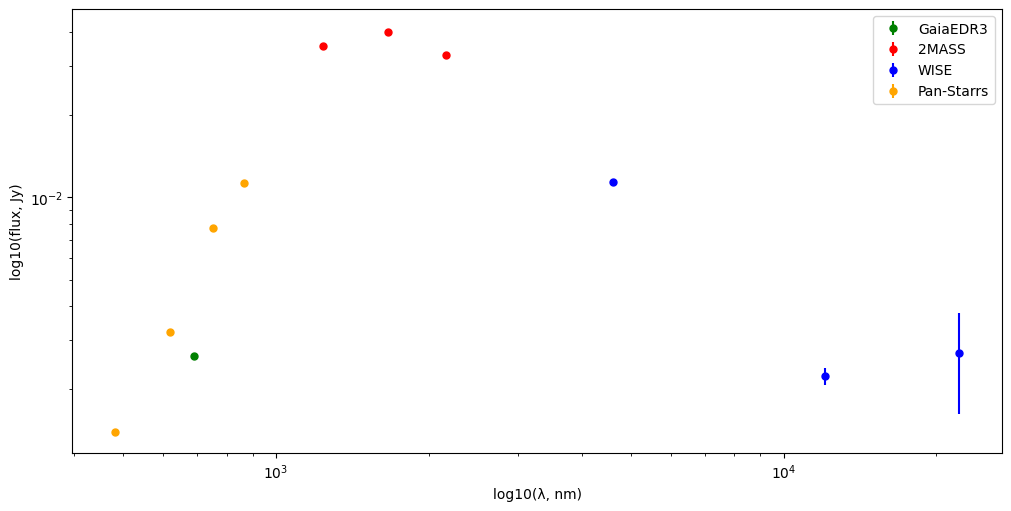

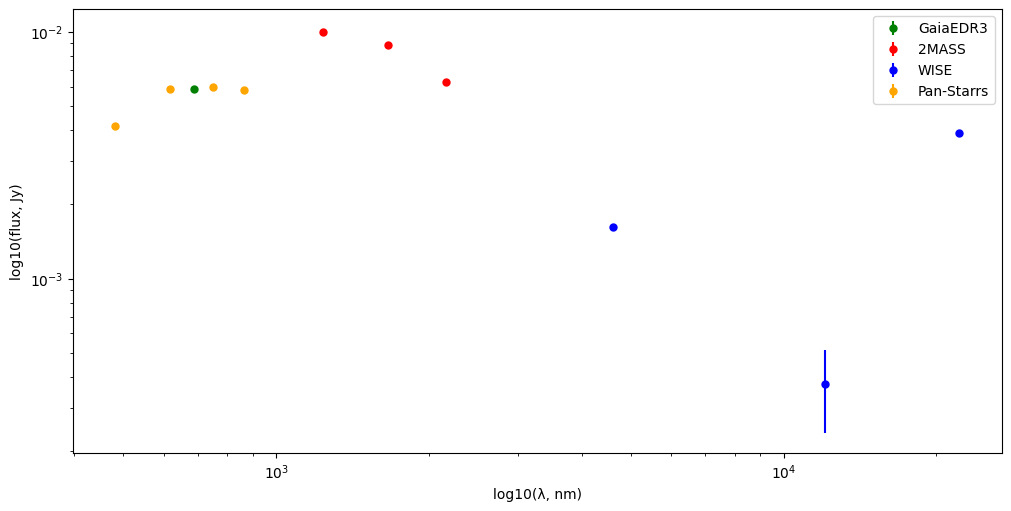

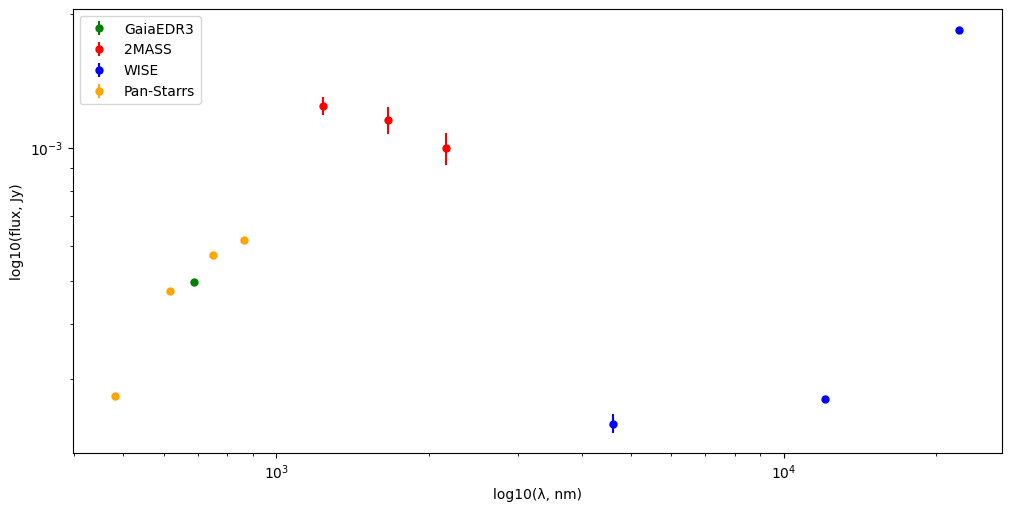

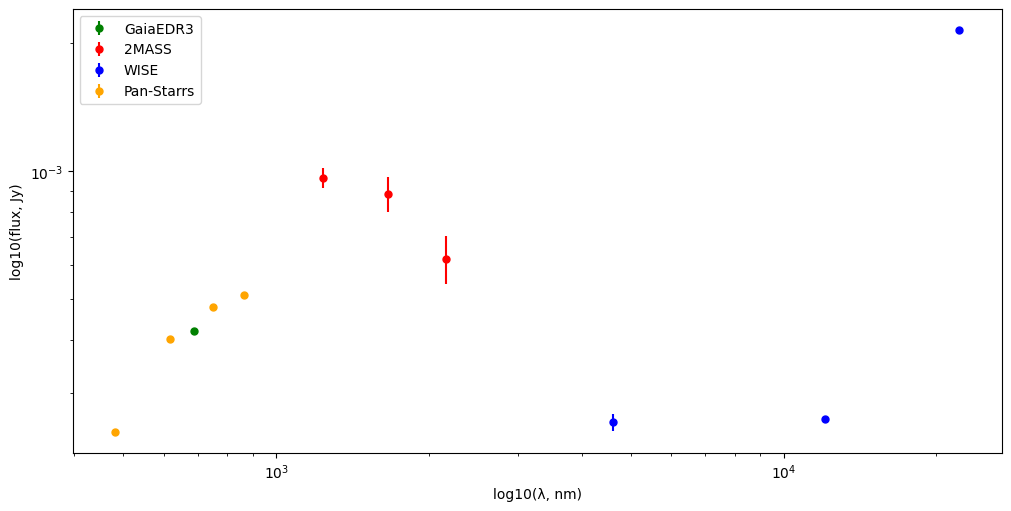

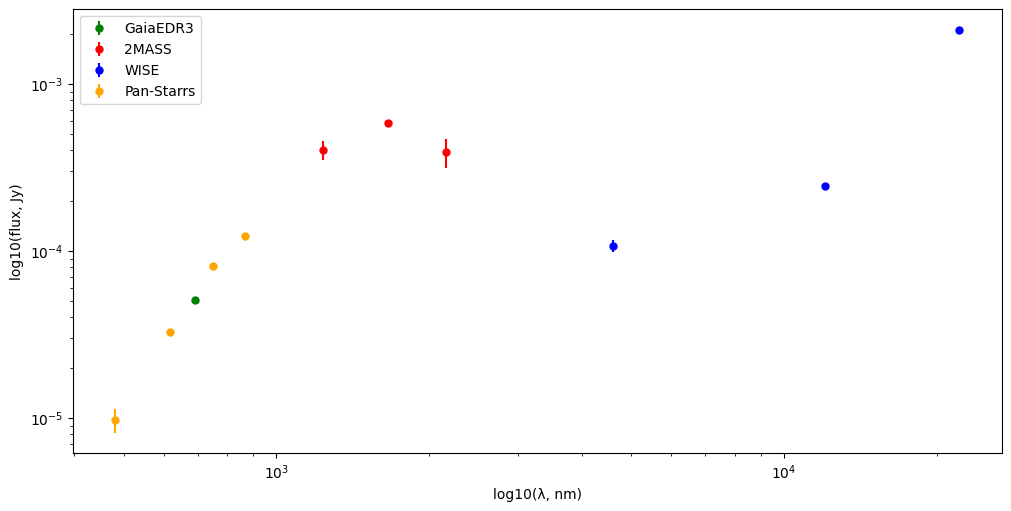

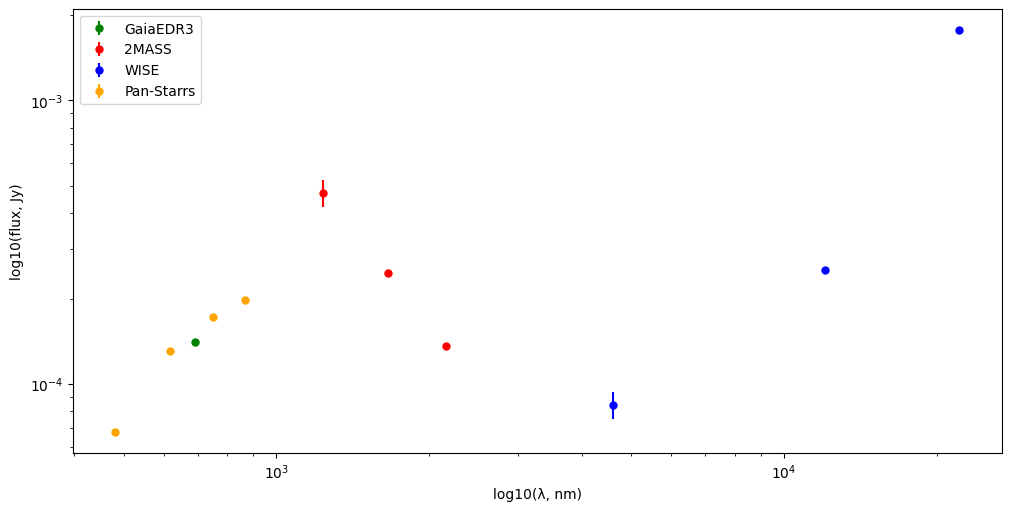

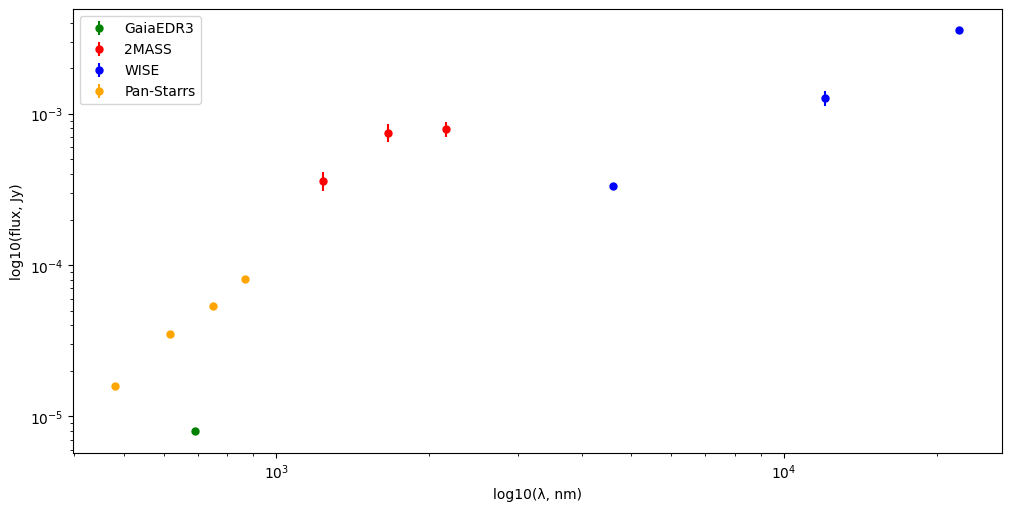

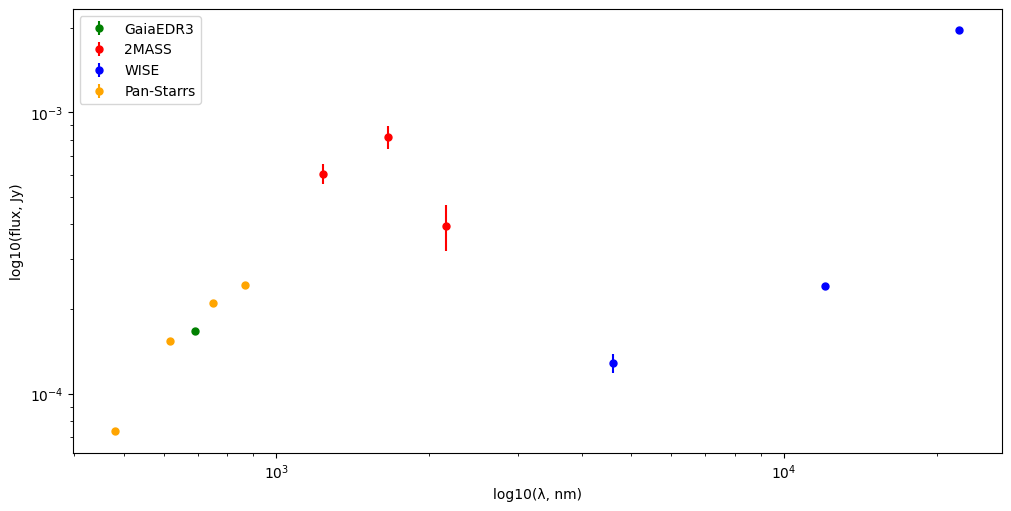

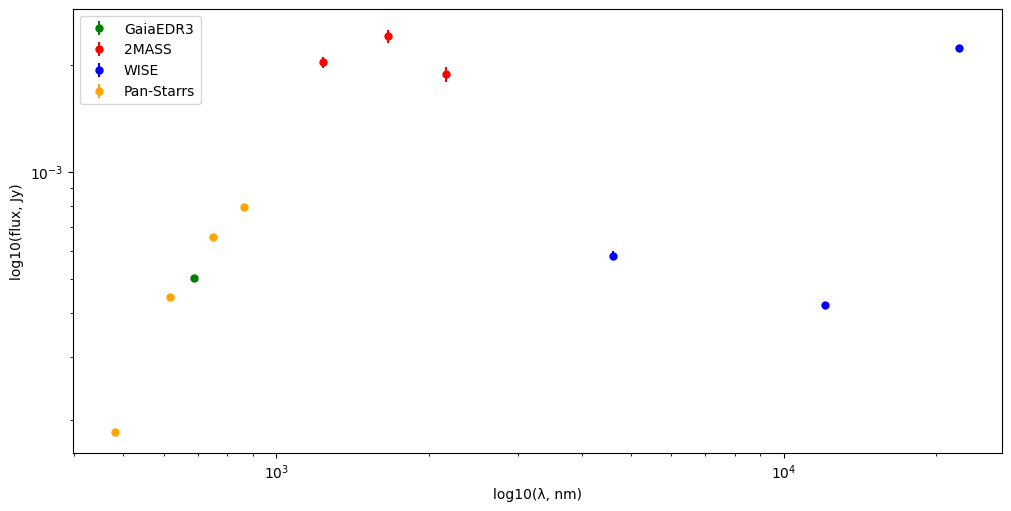

In [13]:
for i in range(len(data)):
    flux = [data[name[j][0]][i] for j in range(len(wl))]
    flux_error = [data[name[j][1]][i] for j in range(len(wl))]
    fig, ax = plt.subplots(figsize=(10, 5), layout='constrained')
    #ax.scatter(np.log10(wl), np.log10(flux), color='black', s=25)
    #ax.errorbar(np.log10(wl), np.log10(flux), yerr=abs(np.log10(flux_error)))
    ax.errorbar(wl[0], flux[0], yerr=flux_error[0], fmt="o", markersize=5, c='green', label='GaiaEDR3')
    ax.errorbar(wl[1:4], flux[1:4], yerr=flux_error[1:4], fmt="o", markersize=5, c='red', label='2MASS')
    ax.errorbar(wl[5:8], flux[5:8], yerr=flux_error[5:8], fmt="o", markersize=5, c='blue', label='WISE')
    ax.errorbar(wl[8:12], flux[8:12], yerr=flux_error[8:12], fmt="o", markersize=5, c='orange', label='Pan-Starrs')
   # ax.set_xscale('log')
   # ax.set_yscale('log')
    ax.set_xlabel('λ, nm')
    ax.set_ylabel('flux, Jy')
    ax.legend()
    plt.show()

In [19]:
data

,RA_ICRS,DE_ICRS,Gmag,e_Gmag,Jmag_2,e_Jmag_2,Hmag_2,e_Hmag_2,Kmag_2,e_Kmag_2,...,r_wl,i_flux,e_i_flux,i_wl,z_flux,e_z_flux,z_wl,y_flux,e_y_flux,y_wl
0,67.653932,64.765727,18.624233,0.003125,15.777,0.084,15.183,0.111,14.950,0.135,...,8021,0.000166,5.812691e-07,9776,0.000221,6.929960e-07,11258,0.000284,0.000005,12506
1,67.638636,64.760427,16.605988,0.002794,14.726,0.036,14.232,0.054,14.089,0.061,...,8021,0.000886,2.856944e-06,9776,0.000985,2.085545e-06,11258,0.001114,0.000006,12506
2,67.599421,64.760521,19.531567,0.003690,16.530,0.133,15.675,0.168,15.437,0.201,...,8021,0.000079,3.282208e-07,9776,0.000124,1.017845e-06,11258,0.000164,0.000004,12506
3,67.623412,64.762207,19.120481,0.017230,15.305,0.048,14.702,0.071,14.501,0.089,...,8021,0.000409,2.144611e-06,9776,0.000497,2.840295e-06,11258,0.000606,0.000004,12506
4,67.634216,64.772178,18.319347,0.002983,14.805,0.042,14.192,0.061,14.082,0.066,...,8021,0.000203,5.226749e-07,9776,0.000252,1.370578e-06,11258,0.000308,0.000007,12506
5,67.634216,64.772178,18.319347,0.002983,14.805,0.042,14.192,0.061,14.082,0.066,...,8021,0.000679,4.379370e-07,9776,0.000757,3.693922e-06,11258,0.000879,0.000006,12506
6,67.632821,64.771881,16.968378,0.002807,14.805,0.042,14.192,0.061,14.082,0.066,...,8021,0.000679,4.379370e-07,9776,0.000757,3.693922e-06,11258,0.000879,0.000006,12506
7,67.632821,64.771881,16.968378,0.002807,14.805,0.042,14.192,0.061,14.082,0.066,...,8021,0.000203,5.226749e-07,9776,0.000252,1.370578e-06,11258,0.000308,0.000007,12506
8,67.623725,64.762287,17.735930,0.003182,15.305,0.048,14.702,0.071,14.501,0.089,...,8021,0.000409,2.144611e-06,9776,0.000497,2.840295e-06,11258,0.000606,0.000004,12506
9,67.589723,64.766164,18.487747,0.003031,16.263,0.113,15.583,0.143,15.179,0.150,...,8021,0.000171,4.869399e-07,9776,0.000208,1.242468e-06,11258,0.000249,0.000004,12506
